In [1]:
import json
from collections import Counter
import pandas as pd
from research.constants import EvalField
from research.utils.hybridqa.hybridqa import hybridqa_metric_format_func
from datasets import load_metric
import copy
import re
import seaborn as sns
import matplotlib.pyplot as plt

04/12/2024 13:02:54 - INFO - datasets -   PyTorch version 2.2.0 available.
04/12/2024 13:02:54 - INFO - datasets -   Apache Beam version 2.50.0 available.


In [12]:
with open("outputs/new-paper-results/hybridqa/gpt-4-blendsql-starcoder2/rerun-predictions.json", "r") as f:
    starcoder = json.load(f)
with open("outputs/new-paper-results/hybridqa/gpt-4-blendsql-only-run5/rerun-predictions.json", "r") as f:
    gpt4 = json.load(f)
with open("outputs/new-paper-results/hybridqa/gpt-4-blendsql-deepseek-coder/rerun-predictions.json", "r") as f:
    deepseek = json.load(f)
results = {
    "starcoder": starcoder,
    "gpt4": gpt4,
    "deepseek": deepseek
}

In [36]:
def is_empty_blendsql_pred(p: list):
    if len(p) == 0 or (
        any(x in str(p[0]) for x in ["table", "passage", "text"])
        and any(x in str(p[0]) for x in ["not", "empty"])
    ) or str(p[0]).strip() == "":
        return True
    return False

def cleanup_error(error: str, prediction: list):
    if error is None:
        if prediction in [[], ['']]:
            return "No Results"
        return error
    error = error.lower()
    if error == "empty subtable passed to qaingredient!":
        return "No Results"
    if error.startswith("the model attempted to generate"):
        return "Constrained Decoding Error"
    elif any(x in error for x in {"no such column", "unknown column"}):
        return "Hallucinated Column"
    elif "fts5: syntax error" in error:
        return "Generic Syntax Error"
    elif "maximum context length is" in error:
        return "Context Overflow"
    elif any(x in error for x in {"error tokenizing", "unbalanced parenthesis", "ambiguous column name", "syntax error", "alias already used", "unterminated subpattern", "invalid expression", "invalid format", "duplicate column name"}):
        return "Generic Syntax Error"
    elif error.startswith("expecting"):
        return "Generic Syntax Error"
    elif "the response was filtered due to the prompt triggering" in error:
        return None
    elif error[0] == "'" and error[-1] == "'":
        return "Generic Syntax Error"
    elif error.startswith("expected }") or 'unrecognized token: "{"' in error:
        return "Generic Syntax Error"
    elif "no such function" in error:
        return "Generic Syntax Error"
    elif "execution failed on sql" in error:
        return "Generic Syntax Error"
    elif "required keyword" in error:
        return "Generic Syntax Error"
    elif re.search(r'\{\{[a-z]\(\)\}\}', error):
        return "Generic Syntax Error"
    return "Generic Syntax Error"

m = load_metric(path="./metrics/hybridqa/")
metric_format_func = hybridqa_metric_format_func

/Users/a720504/miniconda3/envs/blendsql/lib/python3.9/site-packages/datasets/load.py:848: FutureWarning: The repository for hybridqa contains custom code which must be executed to correctly load the metric. You can inspect the repository content at ./metrics/hybridqa/hybridqa.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [4]:
for name, predictions in results.items():
    print(f"HybridQA {name} results:")
    for item in predictions:
        _item = copy.deepcopy(item)
        if is_empty_blendsql_pred(_item[EvalField.PREDICTION]):
            _item[EvalField.PREDICTION] = ""
        m.add(**hybridqa_metric_format_func(item))
    print(json.dumps(m.compute(), indent=4))
    print()

/var/folders/k_/rqtwz3wd3g19jrnz5dkt4d609b2zbl/T/ipykernel_68562/2857013869.py:43: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  m = load_metric(path="./metrics/hybridqa/")
/Users/a720504/miniconda3/envs/blendsql/lib/python3.9/site-packages/datasets/load.py:848: FutureWarning: The repository for hybridqa contains custom code which must be executed to correctly load the metric. You can inspect the repository content at ./metrics/hybridqa/hybridqa.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [38]:
# Create error df
df_list = []
for name, predictions in results.items():
    cleaned_errors = filter(lambda x: x is not None, [cleanup_error(i["error"], i[EvalField.PREDICTION]) for i in predictions])
    for error_type, count in Counter(cleaned_errors).items():
        df_list.append(
            {
                "Model": name,
                "Error Type": error_type,
                "Count": count
            }
        )
df = pd.DataFrame(df_list)

In [26]:
df.groupby("model").sum("count") / len(predictions)

,count
model,
deepseek,0.498413
gpt4,0.234921
starcoder,0.552092


In [27]:
df[~df['error_type'].isin(('empty_results', 'openai_content_management', 'context_overflow'))].groupby("model").sum("count") / len(predictions)

,count
model,
deepseek,0.498413
gpt4,0.234921
starcoder,0.552092


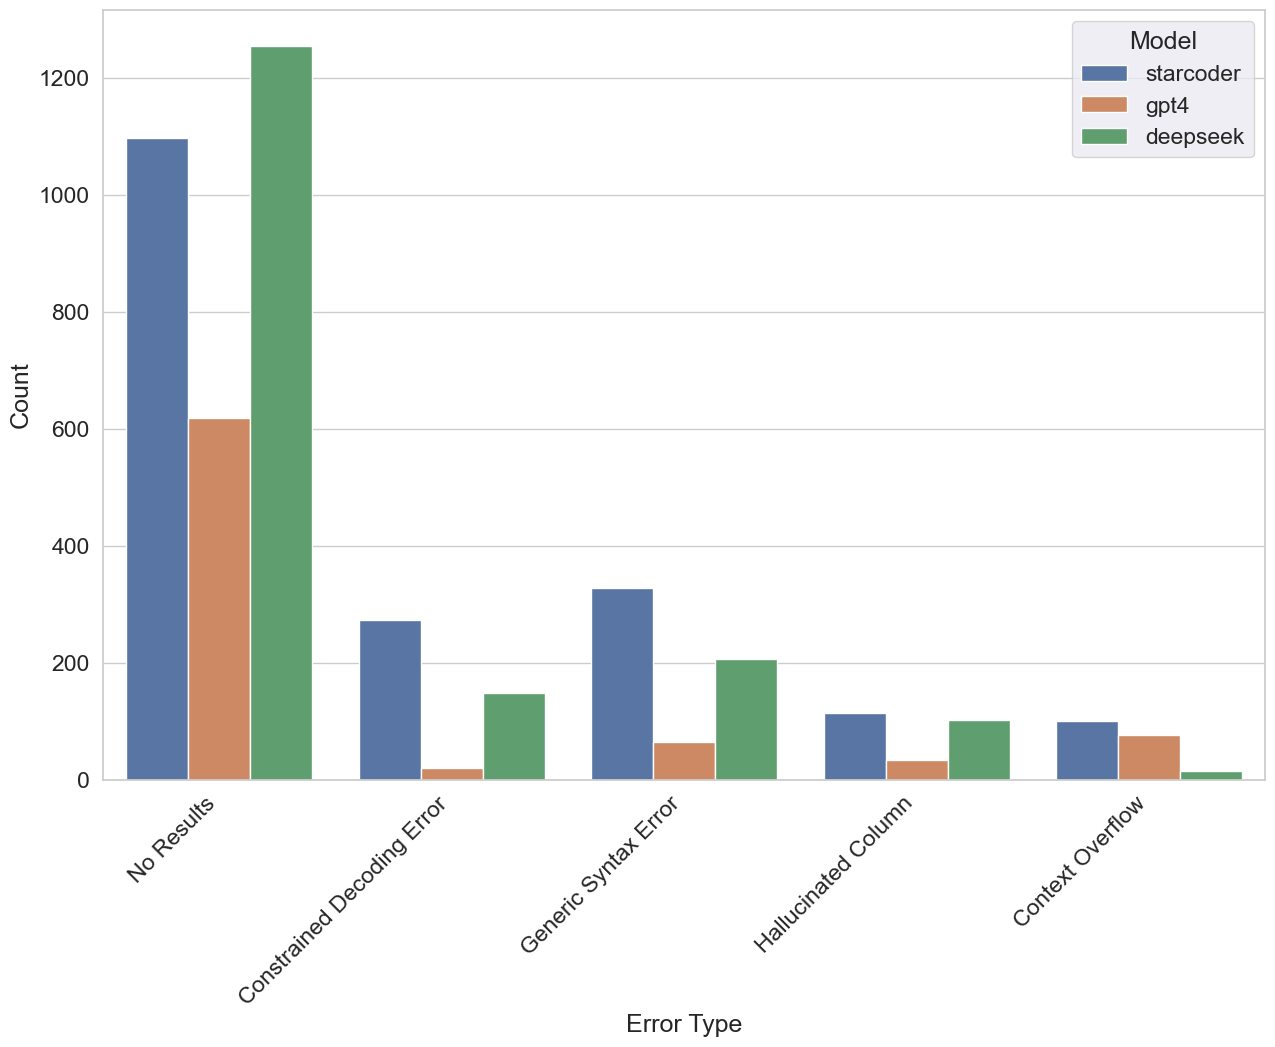

In [45]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15, 10))
sns.set(font_scale = 1.5)
sns.barplot(
    data=df,
    x="Error Type",
    y="Count",
    hue="Model"
)
plt.xticks(rotation=45, ha="right")
plt.savefig(
        f"syntax_error_comparisons.png",
        dpi=200,
        bbox_inches="tight",
        pad_inches=0.2,
        facecolor="w",
    )